<a href="https://colab.research.google.com/github/Angelaestefan/concentracion/blob/master/ejemplos_tema3_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Esta libreta es una traducción de:
https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb#scrollTo=Mu3PR3aMH64U

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
from scipy import stats

## Máquinas de vectores de soporte - Motivación
Para comenzar, suponga que tenemos una tarea de clasificación en el que los dos tipos de clases están bien separados.


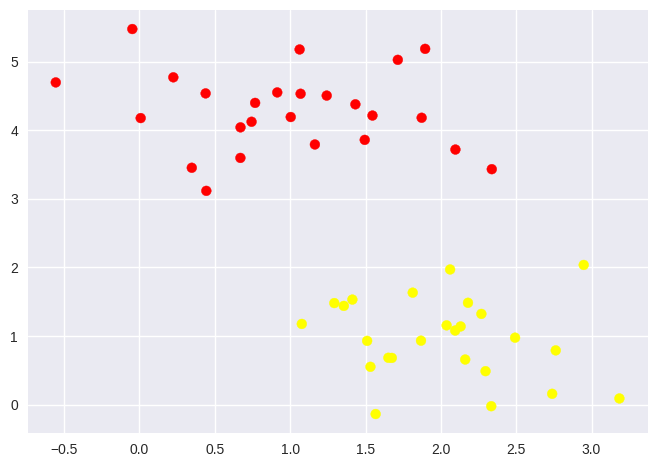

In [15]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

Un clasificador discriminativo lineal intentaría dibujar una línea recta que separara los dos conjuntos de datos y, de este modo, crear un modelo de clasificación. Para datos bidimensionales como los que se muestran aquí, esta tarea podría realizarse manualmente. Pero inmediatamente surge un problema: ¡existe más de una línea divisoria posible que puede discriminar perfectamente entre las dos clases!

Podemos dibujar algunas de ellas de la siguiente manera; la siguiente figura muestra el resultado:

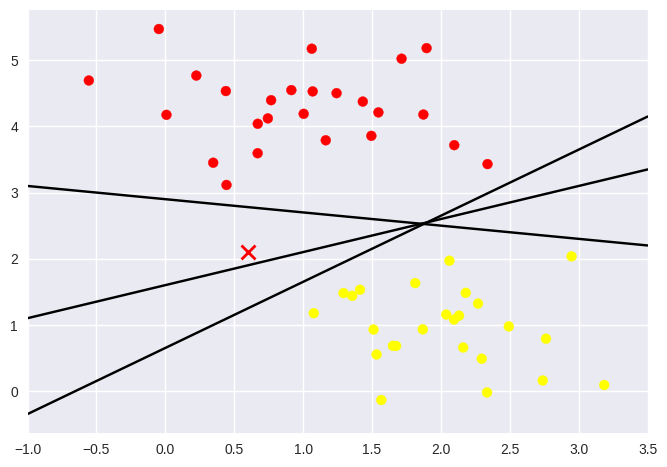

In [16]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

Se trata de tres separadores *muy* diferentes que, sin embargo, discriminan perfectamente entre estas muestras.
Dependiendo de cuál elija, a un nuevo punto de datos (por ejemplo, el marcado con la "X" en este gráfico) se le asignará una etiqueta diferente.
Evidentemente, nuestra simple intuición de "trazar una línea entre clases" no es suficiente, y necesitamos reflexionar con más profundidad.

# Máquinas de soporte de vectores: maximización del margen

Las máquinas de vectores de soporte ofrecen una manera de mejorar esto. La intuición es la siguiente: en lugar de simplemente trazar una línea de ancho cero entre las clases, podemos trazar alrededor de cada línea un margen de cierto ancho, hasta el punto más cercano. Aquí tienes un ejemplo de cómo podría verse (ver la siguiente figura):”

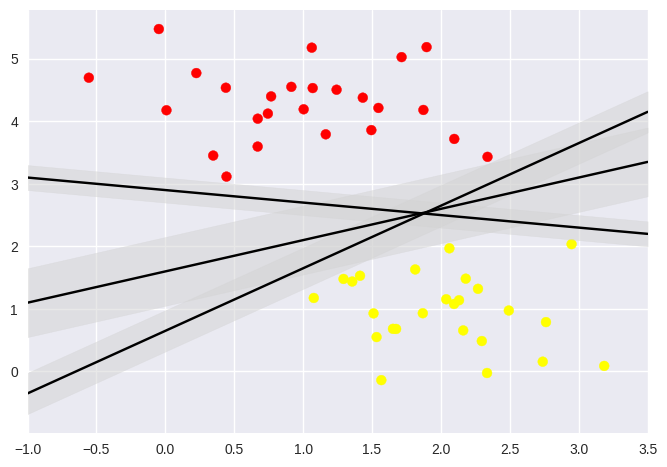

In [17]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='lightgray', alpha=0.5)

plt.xlim(-1, 3.5);

La línea que maximice este margen es la que elegiremos como modelo óptimo.

# Ajustando una máquina de soporte vectorial

Veamos el resultado de un ajuste real a estos datos: utilizaremos el clasificador de vectores de soporte (SVC) de Scikit-Learn para entrenar un modelo SVM con estos datos. Por ahora, utilizaremos un kernel lineal y estableceremos el parámetro C en un valor muy alto (profundizaremos en su significado más adelante).

In [18]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

,C,10000000000.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False



Para visualizar mejor lo que sucede aquí, creemos una función de conveniencia rápida que trazará los límites de decisión de SVM para nosotros (vea la siguiente figura):

In [19]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, edgecolors='black',
                   facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

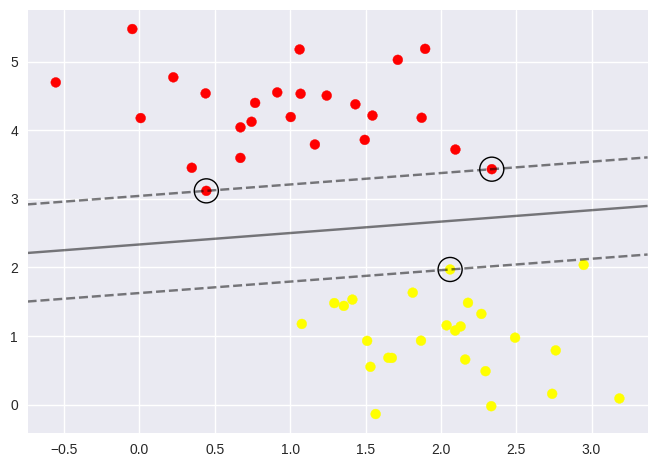

In [20]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

Esta es la línea divisoria que maximiza el margen entre los dos conjuntos de puntos.
Observe que algunos puntos de entrenamiento apenas tocan el margen: están rodeados con un círculo en la siguiente figura.
Estos puntos son los elementos clave de este ajuste; se conocen como *vectores de soporte* y dan nombre al algoritmo.
En Scikit-Learn, las identidades de estos puntos se almacenan en el atributo `support_vectors_` del clasificador:

In [21]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

Una clave del éxito de este clasificador es que, para el ajuste, solo importan las posiciones de los vectores de soporte; los puntos más alejados del margen que estén en el lado correcto no modifican el ajuste. Técnicamente, esto se debe a que estos puntos no contribuyen a la función de pérdida utilizada para ajustar el modelo, por lo que su posición y número no importan siempre que no crucen el margen.

Podemos comprobarlo, por ejemplo, si graficamos el modelo aprendido a partir de los primeros 60 y 120 puntos de este conjunto de datos (véase la siguiente figura):


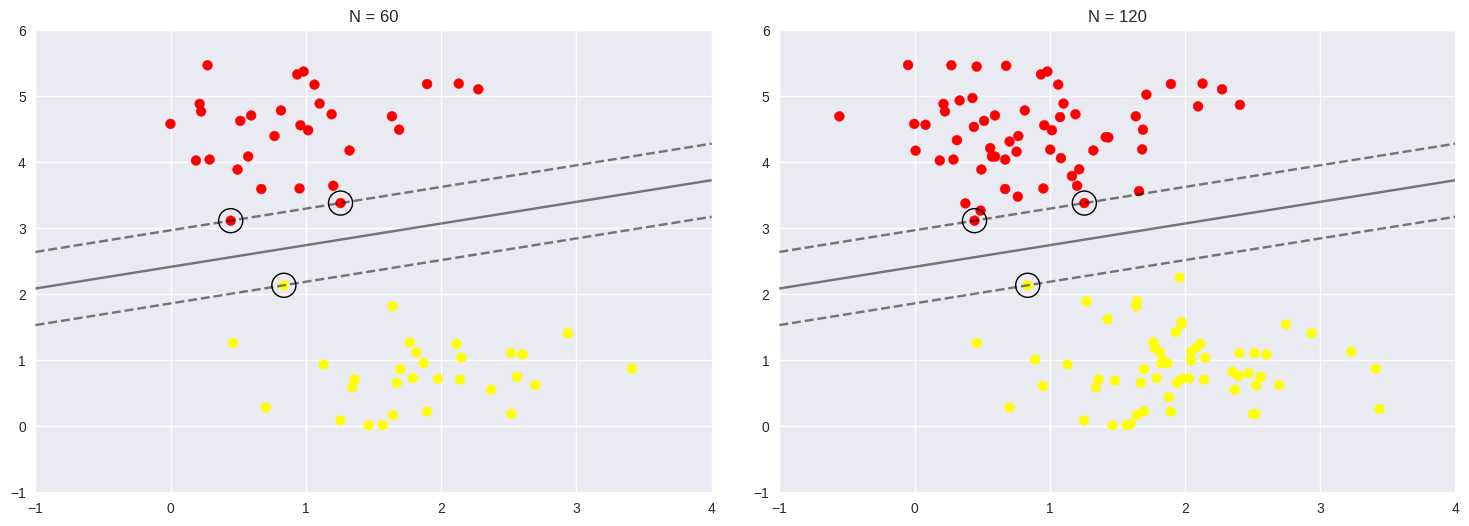

In [22]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)

    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

En el panel izquierdo, vemos el modelo y los vectores de soporte para 60 puntos de entrenamiento.
En el panel derecho, hemos duplicado el número de puntos de entrenamiento, pero el modelo no ha cambiado: los tres vectores de soporte del panel izquierdo son los mismos que los del panel derecho.
Esta insensibilidad al comportamiento exacto de los puntos distantes es una de las fortalezas del modelo SVM.

Si está ejecutando este cuaderno en vivo, puede usar los widgets interactivos de IPython para ver esta característica del modelo SVM de forma interactiva:

(Descomentar y correr las siguientes líneas, pero cuidado puede tardar mucho tiempo.)

In [23]:
# from ipywidgets import interact, fixed
# interact(plot_svm, N=(10, 200), ax=fixed(None));

### Ajuste de la máquina de vectores de soporte: Margen blando

Hasta ahora, nuestro análisis se ha centrado en conjuntos de datos muy limpios, en los que existe un límite de decisión perfecto.
Pero ¿qué ocurre si sus datos presentan cierta superposición?
Por ejemplo, podría tener datos como estos (véase la siguiente figura):

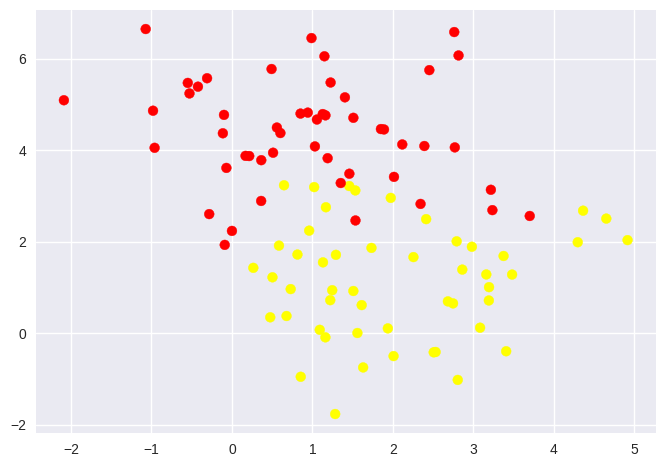

In [24]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Para abordar este caso, la implementación de SVM cuenta con un factor de ajuste que "suaviza" el margen: es decir, permite que algunos puntos se deslicen hacia el margen si esto facilita un mejor ajuste.
La dureza del margen se controla mediante un parámetro de ajuste, comúnmente conocido como `C`.
Para una `C` muy grande, el margen es duro y los puntos no pueden estar en él.
Para una `C` más pequeña, el margen es más suave y puede crecer hasta abarcar algunos puntos.

La gráfica que se muestra en la siguiente figura muestra cómo un cambio en la `C` afecta el ajuste final mediante la suavización del margen:


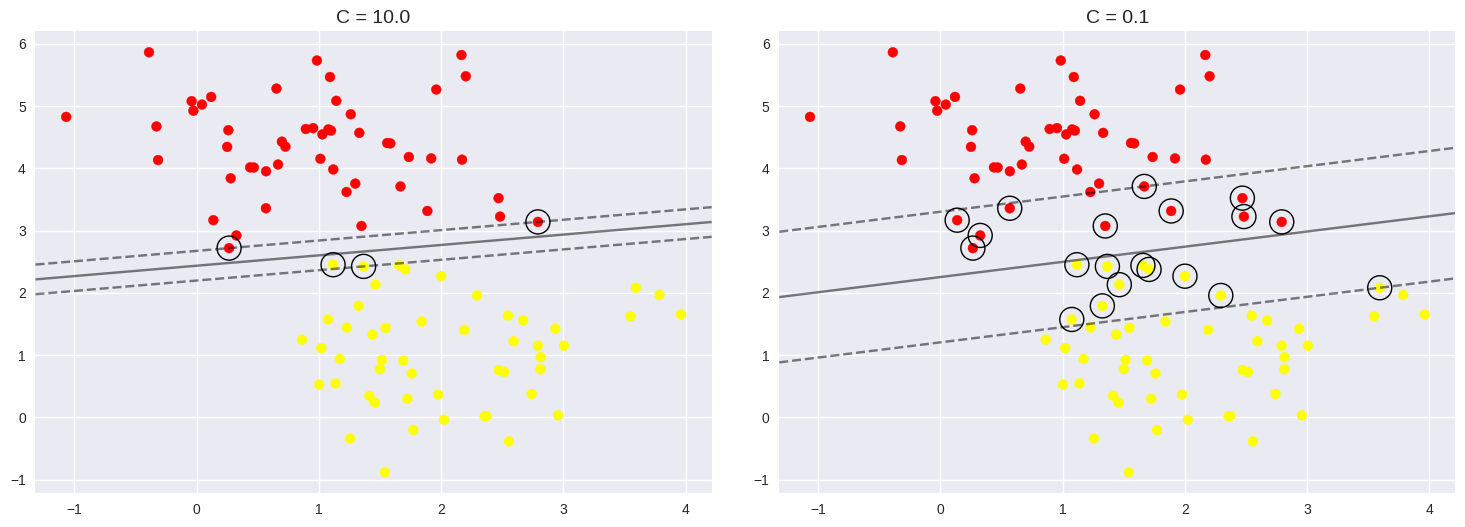

In [25]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)


El valor óptimo de "C" dependerá de su conjunto de datos, y debe ajustar este parámetro mediante validación cruzada o un procedimiento similar (consulte [Hiperparámetros y validación del modelo](05.03-Hyperparameters-and-Model-Validation.ipynb)).

### Más allá de los límites lineales: SVM de kernel

El SVM puede ser muy eficaz al combinarse con *kernels*. La idea es proyectar los datos a un espacio de mayor dimensionalidad donde los datos puedan ser linealmente serapables. Para justificar la necesidad de kernels, veamos algunos datos que no son linealmente separables (véase la siguiente figura):

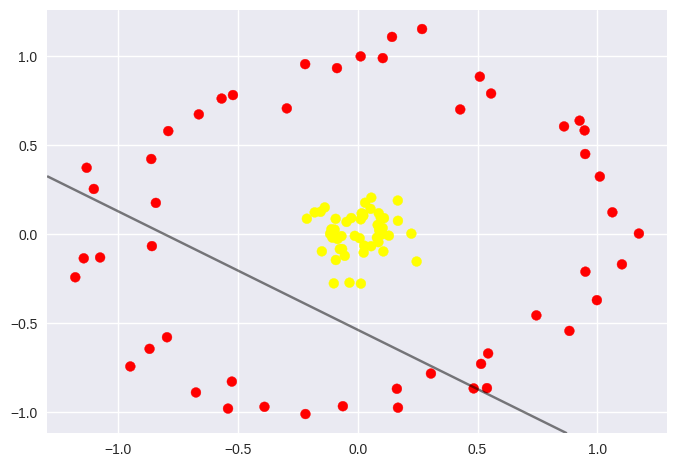

In [26]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Es evidente que ninguna discriminación lineal podrá separar estos datos.
Pero podemos pensar en cómo podríamos proyectar los datos a una dimensión superior de modo que un separador lineal sea suficiente.
Por ejemplo, una proyección sencilla que podríamos usar sería calcular una *función base radial* (RBF) centrada en el grupo central:

In [27]:
r = np.exp(-(X ** 2).sum(1))
print("Shape X: ", X.shape)
print("Shape r: ", r.shape)

Shape X:  (100, 2)
Shape r:  (100,)


Podemos visualizar esta dimensión de datos adicionales utilizando un gráfico tridimensional, como se ve en la siguiente figura:

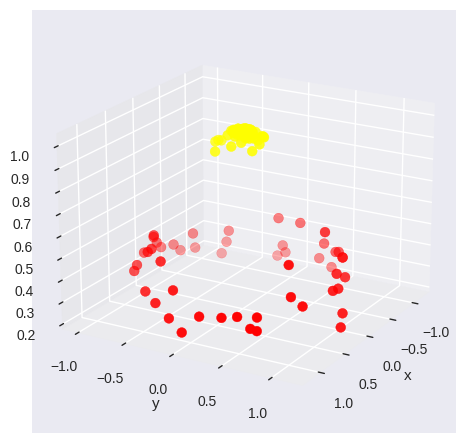

In [28]:
from mpl_toolkits import mplot3d

ax = plt.subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
ax.view_init(elev=20, azim=30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('r');

Podemos observar que, con esta dimensión adicional, los datos se vuelven fácilmente separables linealmente, dibujando un plano de separación en, por ejemplo, *r*=0,7.

En este caso, tuvimos que elegir y ajustar cuidadosamente nuestra proyección: si no hubiéramos centrado nuestra función de base radial en la ubicación correcta, no habríamos obtenido resultados tan limpios y linealmente separables.
En general, la necesidad de hacer tal elección es un problema: nos gustaría encontrar de alguna manera automáticamente las mejores funciones de base para usar.

Una estrategia para este fin es calcular una función de base centrada en *cada* punto del conjunto de datos y dejar que el algoritmo SVM filtre los resultados.
Este tipo de transformación de la función de base se conoce como *transformación kernel*, ya que se basa en una relación de similitud (o kernel) entre cada par de puntos.

Un problema potencial con esta estrategia (proyectar $N$ puntos en $N$ dimensiones) es que podría volverse muy intensiva computacionalmente a medida que $N$ aumenta. Sin embargo, gracias a un sencillo procedimiento conocido como el [*truco del kernel*](https://en.wikipedia.org/wiki/Kernel_trick), se puede realizar un ajuste en datos transformados por kernel de forma implícita, es decir, sin construir la representación completa de $N$ dimensiones de la proyección del kernel.
Este truco del kernel está integrado en la SVM y es una de las razones por las que el método es tan eficaz.

En Scikit-Learn, podemos aplicar la SVM kernelizada simplemente cambiando nuestro kernel lineal a un kernel RBF, utilizando el hiperparámetro del modelo `kernel`:

In [29]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

,C,1000000.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


Let's use our previously defined function to visualize the fit and identify the support vectors (see the following figure):

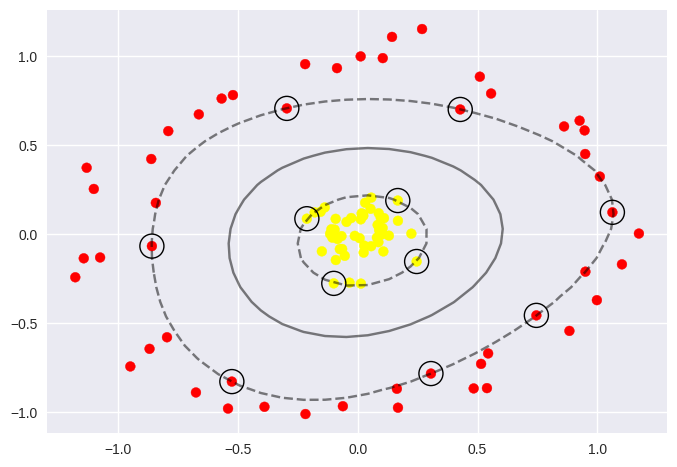

In [30]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Utilizando esta máquina de vectores de soporte kernelizada, aprendemos un límite de decisión no lineal adecuado.
Esta estrategia de transformación kernel se utiliza a menudo en el aprendizaje automático para convertir métodos lineales rápidos en métodos no lineales rápidos, especialmente para modelos en los que se puede utilizar el truco kernel.


### Ejemplo: Reconocimiento facial

Como ejemplo de máquinas de vectores de soporte en acción, analicemos el problema del reconocimiento facial.
Utilizaremos el conjunto de datos "Rostros etiquetados en la naturaleza", que consta de miles de fotos recopiladas de diversas figuras públicas.
Scikit-Learn integra un buscador para el conjunto de datos:

In [31]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Vamos a graficar algunas muestras

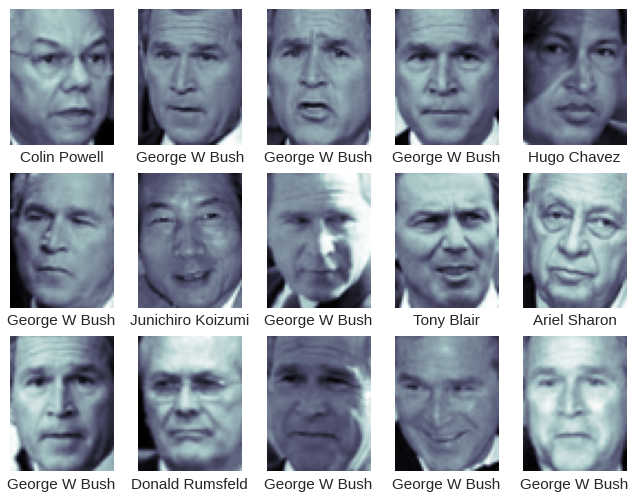

In [32]:

fig, ax = plt.subplots(3, 5, figsize=(8, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Cada imagen contiene 62 × 47, o aproximadamente 3000 píxeles. Podríamos proceder simplemente usando cada valor de píxel como una característica, pero a menudo resulta más efectivo usar algún tipo de preprocesador para extraer características más significativas. En este caso, utilizaremos el análisis de componentes principales (véase "A fondo: Análisis de componentes principales") para extraer 150 componentes fundamentales que alimentaremos a nuestro clasificador de máquinas de vectores de soporte. Podemos hacerlo de forma más sencilla empaquetando el preprocesador y el clasificador en una sola canalización:

In [33]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True,
          svd_solver='randomized', random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

Para probar la salida de nuestro clasificador, dividiremos los datos en un conjunto de entrenamiento y un conjunto de prueba:

In [34]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Finalmente, podemos usar la validación cruzada de búsqueda en cuadrícula para explorar combinaciones de parámetros.
Aquí ajustaremos ``C`` (que controla la dureza del margen) y ``gamma`` (que controla el tamaño del kernel de la función de base radial) y determinaremos el mejor modelo:

In [35]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 51min, sys: 9.81 s, total: 51min 10s
Wall time: 2min 49s
{'svc__C': 5, 'svc__gamma': 0.001}


Los valores óptimos se encuentran hacia el centro de nuestra cuadrícula; si se encuentran en los extremos, sería conveniente expandir la cuadrícula para asegurarnos de haber encontrado el valor óptimo real.

Ahora, con este modelo de validación cruzada, podemos predecir las etiquetas de los datos de prueba, que el modelo aún no ha detectado:

In [36]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Echemos un vistazo a algunas de las imágenes de prueba junto con sus valores previstos (consulte la siguiente figura):

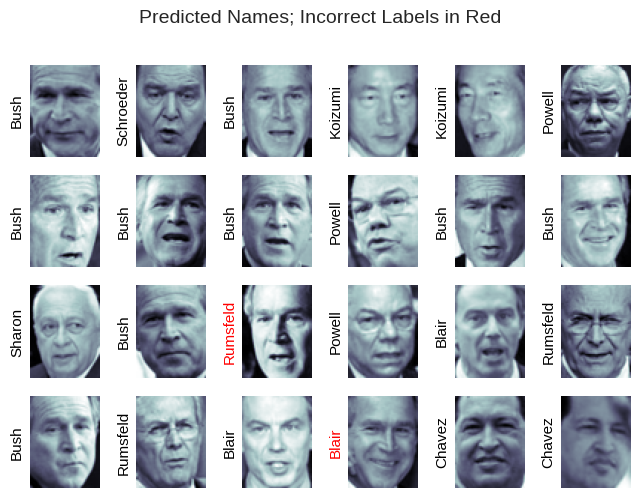

In [37]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Podemos comprender mejor el rendimiento de nuestro estimador utilizando el informe de clasificación, que muestra las estadísticas de recuperación etiqueta por etiqueta:

In [38]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.83      0.88      0.86        68
  Donald Rumsfeld       0.70      0.84      0.76        31
    George W Bush       0.97      0.80      0.88       126
Gerhard Schroeder       0.76      0.83      0.79        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.82      0.98      0.89        42

         accuracy                           0.85       337
        macro avg       0.82      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



También podemos mostrar la matriz de confusión entre estas clases (ver la siguiente figura):

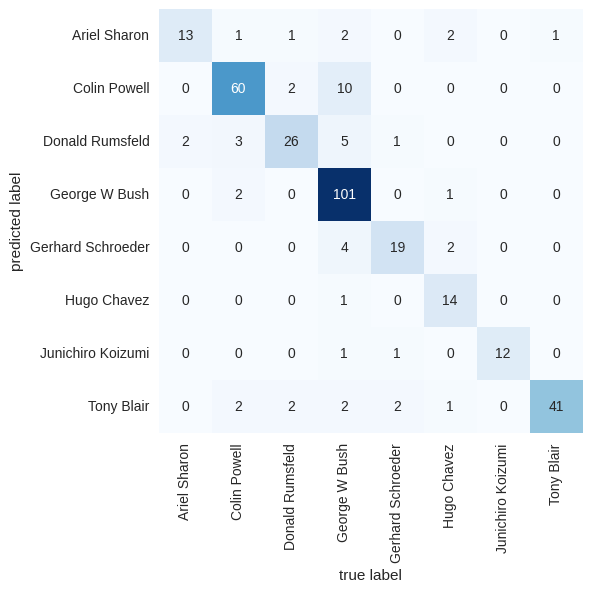

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Esto nos ayuda a comprender qué etiquetas podrían ser confundidas por el estimador.

Para una tarea de reconocimiento facial real, donde las fotos no vienen precortadas en cuadrículas definidas, la única diferencia en el esquema de clasificación facial es la selección de características: se necesitaría un algoritmo más sofisticado para encontrar los rostros y extraer características independientes de la pixelación. Para este tipo de aplicación, una buena opción es usar OpenCV, que, entre otras cosas, incluye implementaciones preentrenadas de herramientas de extracción de características de vanguardia para imágenes en general y rostros en particular.

## Resumen

Esta ha sido una breve introducción intuitiva a los principios de las máquinas de vectores de soporte.
Estos modelos constituyen un potente método de clasificación por varias razones:

- Su dependencia de relativamente pocos vectores de soporte significa que son compactos y ocupan muy poca memoria.
- Una vez entrenado el modelo, la fase de predicción es muy rápida.
- Dado que solo se ven afectados por los puntos cercanos al margen, funcionan bien con datos de alta dimensión, incluso con datos con más dimensiones que las muestras, lo cual supone un reto para otros algoritmos.
- Su integración con los métodos kernel los hace muy versátiles, capaces de adaptarse a diversos tipos de datos.

Sin embargo, las SVM también presentan varias desventajas:

- El escalado con el número de muestras $N$ es $\mathcal{O}[N^3]$ en el peor de los casos, o $\mathcal{O}[N^2]$ para implementaciones eficientes. Para un gran número de muestras de entrenamiento, este coste computacional puede ser prohibitivo.

Los resultados dependen en gran medida de la elección adecuada del parámetro de suavizado «C». Este debe seleccionarse cuidadosamente mediante validación cruzada, lo cual puede resultar costoso a medida que aumentan el tamaño de los conjuntos de datos.
Los resultados no tienen una interpretación probabilística directa. Esto puede estimarse mediante una validación cruzada interna (véase el parámetro «probabilidad» de «SVC»), pero esta estimación adicional es costosa.

Teniendo en cuenta estas características, generalmente solo recurro a las SVM cuando otros métodos más sencillos, rápidos y que requieren menos ajustes han demostrado ser insuficientes para mis necesidades.
Sin embargo, si dispone de los ciclos de CPU necesarios para entrenar y validar una SVM con sus datos, el método puede ofrecer excelentes resultados.






